LSTM performance with vs. without sentiment

In [48]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("Financial_News_Articles_new.csv")

#Aggregate all features and y values per day
df_daily = df.groupby("date").agg({
    'ret_lag1': 'mean',
    'ret_roll5': 'mean',
    'vix_lag1': 'mean',
    'vix_chg1': 'mean',
    'polarity_x_strong_lag1': 'mean',
    'polarity_x_strong_roll3': 'mean',
    'y': 'mean'   # target
}).reset_index()

#Smooth the y column
df_daily['y'] = df_daily['y'].rolling(3).mean()

#Drop NaNs caused by rolling
df_daily = df_daily.dropna().reset_index(drop=True)

#Check shape
print("Original rows:", df.shape[0])
print("After daily aggregation:", df_daily.shape[0])
df_daily.head()
df = df_daily

features_with_sentiment = ['ret_lag1', 'ret_roll5', 'vix_lag1', 'vix_chg1', 'polarity_x_strong_lag1', 'polarity_x_strong_roll3']
features_without_sentiment = ['ret_lag1', 'ret_roll5', 'vix_lag1', 'vix_chg1']
target = df['y'].values


Original rows: 1908
After daily aggregation: 1906


In [50]:
#Scale Features and Create Sequences

scaler_with = StandardScaler().fit(df[features_with_sentiment])
X_with = scaler_with.transform(df[features_with_sentiment])

scaler_without = StandardScaler().fit(df[features_without_sentiment])
X_without = scaler_without.transform(df[features_without_sentiment])

scaler_y = StandardScaler()
y = scaler_y.fit_transform(target.reshape(-1, 1)).squeeze()

#Use the past 40 days to predict the next 1 day.
def create_sequences(X, y, length=40):
    X_seq, y_seq = [], []
    for i in range(len(X) - length):
        X_seq.append(X[i:i+length])
        y_seq.append(y[i+length])
    return np.array(X_seq), np.array(y_seq)

X_seq_with, y_seq_with = create_sequences(X_with, y)
X_seq_without, y_seq_without = create_sequences(X_without, y)


In [51]:
#Train-Test Split and DataLoader Setup (80% Training) (20% Testing)

def split(X, y, ratio=0.8):
    idx = int(len(X) * ratio)
    return X[:idx], y[:idx], X[idx:], y[idx:]

X_train_w, y_train_w, X_test_w, y_test_w = split(X_seq_with, y_seq_with)
X_train_wo, y_train_wo, X_test_wo, y_test_wo = split(X_seq_without, y_seq_without)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

batch_size = 32
train_loader_w = DataLoader(TimeSeriesDataset(X_train_w, y_train_w), batch_size=batch_size, shuffle=True)
test_loader_w = DataLoader(TimeSeriesDataset(X_test_w, y_test_w), batch_size=batch_size)
train_loader_wo = DataLoader(TimeSeriesDataset(X_train_wo, y_train_wo), batch_size=batch_size, shuffle=True)
test_loader_wo = DataLoader(TimeSeriesDataset(X_test_wo, y_test_wo), batch_size=batch_size)


In [52]:
#Define LSTM Model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden, layers, out):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden, layers, batch_first=True)
        self.fc = nn.Linear(hidden, out)
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)
        c0 = torch.zeros(2, x.size(0), 128).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :]).squeeze(1)


In [54]:
#Train Function

def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=20):
    device = next(model.parameters()).device
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            total += loss.item()
        train_losses.append(total / len(train_loader))

        with torch.no_grad():
            model.eval()
            val_loss = sum(criterion(model(x.to(device)), y.to(device)).item()
                           for x, y in test_loader) / len(test_loader)
            test_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train {train_losses[-1]:.4f}, Test {test_losses[-1]:.4f}")
    
    return train_losses, test_losses




In [55]:
#Initialize & Train Both Models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_w = LSTM(X_seq_with.shape[2], 128, 2, 1).to(device)
model_wo = LSTM(X_seq_without.shape[2], 128, 2, 1).to(device)

opt_w = torch.optim.Adam(model_w.parameters(), lr=1e-3)
opt_wo = torch.optim.Adam(model_wo.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_losses_w, test_losses_w = train_model(model_w, train_loader_w, test_loader_w, opt_w, loss_fn)
train_losses_wo, test_losses_wo = train_model(model_wo, train_loader_wo, test_loader_wo, opt_wo, loss_fn)



Epoch 1: Train 1.0654, Test 0.3230
Epoch 2: Train 0.7416, Test 0.2020
Epoch 3: Train 0.6543, Test 0.2013
Epoch 4: Train 0.6248, Test 0.1960
Epoch 5: Train 0.6002, Test 0.1969
Epoch 6: Train 0.5705, Test 0.1935
Epoch 7: Train 0.5495, Test 0.1941
Epoch 8: Train 0.5225, Test 0.1975
Epoch 9: Train 0.5331, Test 0.1937
Epoch 10: Train 0.5050, Test 0.1955
Epoch 11: Train 0.4850, Test 0.1974
Epoch 12: Train 0.4471, Test 0.2085
Epoch 13: Train 0.4369, Test 0.2012
Epoch 14: Train 0.4134, Test 0.2047
Epoch 15: Train 0.4141, Test 0.2115
Epoch 16: Train 0.3853, Test 0.2056
Epoch 17: Train 0.3431, Test 0.2097
Epoch 18: Train 0.3303, Test 0.1981
Epoch 19: Train 0.3213, Test 0.1965
Epoch 20: Train 0.3110, Test 0.2007
Epoch 1: Train 1.0506, Test 0.2812
Epoch 2: Train 0.7158, Test 0.1990
Epoch 3: Train 0.6484, Test 0.1947
Epoch 4: Train 0.6136, Test 0.1870
Epoch 5: Train 0.6072, Test 0.2070
Epoch 6: Train 0.5738, Test 0.2025
Epoch 7: Train 0.5528, Test 0.1919
Epoch 8: Train 0.5447, Test 0.1875
Epoch 9: 

In [56]:
#Evaluation Metrics & Predictions

def evaluate_model(model, X_seq, y_seq, scaler_y):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)
        preds = model(X_tensor).cpu().numpy()
        actuals = y_tensor.cpu().numpy()

    y_pred_inv = scaler_y.inverse_transform(preds.reshape(-1, 1)).squeeze()
    y_actual_inv = scaler_y.inverse_transform(actuals.reshape(-1, 1)).squeeze()

    mae = mean_absolute_error(y_actual_inv, y_pred_inv)
    rmse = mean_squared_error(y_actual_inv, y_pred_inv, squared=False)
    test_loss = mean_squared_error(y_actual_inv, y_pred_inv)

    return {
        "mae": mae,
        "rmse": rmse,
        "test_loss": test_loss,
        "y_actual": y_actual_inv,
        "y_predicted": y_pred_inv
    }

results_with_sentiment = evaluate_model(model_w, X_seq_with, y_seq_with, scaler_y)
results_without_sentiment = evaluate_model(model_wo, X_seq_without, y_seq_without, scaler_y)


In [57]:
#Display Results

print("With Sentiment")
print("MAE:", results_with_sentiment["mae"])
print("RMSE:", results_with_sentiment["rmse"])
print("Test Loss:", results_with_sentiment["test_loss"])

print("\nWithout Sentiment")
print("MAE:", results_without_sentiment["mae"])
print("RMSE:", results_without_sentiment["rmse"])
print("Test Loss:", results_without_sentiment["test_loss"])


With Sentiment
MAE: 0.003814063
RMSE: 0.0052309204
Test Loss: 2.7362526e-05

Without Sentiment
MAE: 0.0038202116
RMSE: 0.005519915
Test Loss: 3.046946e-05


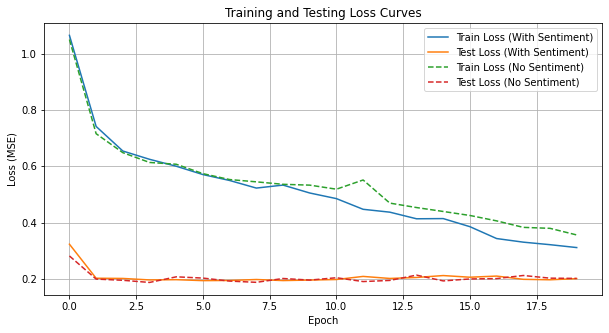

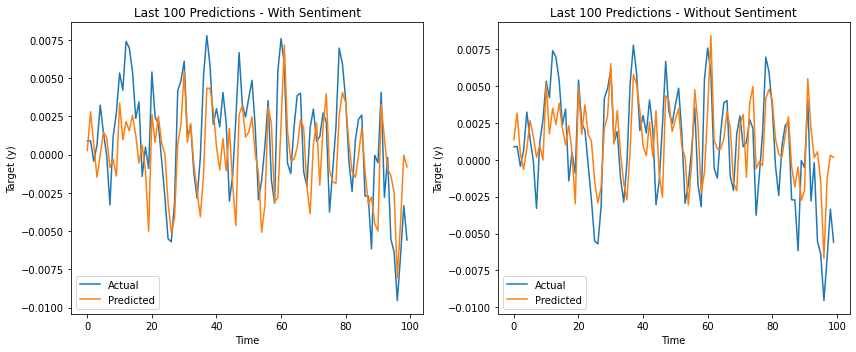

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_w, label="Train Loss (With Sentiment)")
plt.plot(test_losses_w, label="Test Loss (With Sentiment)")
plt.plot(train_losses_wo, label="Train Loss (No Sentiment)", linestyle='--')
plt.plot(test_losses_wo, label="Test Loss (No Sentiment)", linestyle='--')
plt.title("Training and Testing Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))

# With Sentiment
plt.subplot(1, 2, 1)
plt.plot(results_with_sentiment["y_actual"][-100:], label="Actual")
plt.plot(results_with_sentiment["y_predicted"][-100:], label="Predicted")
plt.title("Last 100 Predictions - With Sentiment")
plt.xlabel("Time")
plt.ylabel("Target (y)")
plt.legend()

# Without Sentiment
plt.subplot(1, 2, 2)
plt.plot(results_without_sentiment["y_actual"][-100:], label="Actual")
plt.plot(results_without_sentiment["y_predicted"][-100:], label="Predicted")
plt.title("Last 100 Predictions - Without Sentiment")
plt.xlabel("Time")
plt.ylabel("Target (y)")
plt.legend()

plt.tight_layout()
plt.show()




In [59]:
#Get full set of target dates (aligned with y)
date_series = df['date'].values[40:]  #first 40 are lost in sequence

#Get the test dates only
split_index = int(len(date_series) * 0.8)
test_dates = date_series[split_index:]  # 20% test set

#Get last 100 dates of the test set to match your 100 predictions
final_100_dates = test_dates[-100:]

df_compare = pd.DataFrame({
    "Date": final_100_dates,
    "Actual_Y_With_Sentiment": results_with_sentiment["y_actual"][-100:],
    "Predicted_Y_With_Sentiment": results_with_sentiment["y_predicted"][-100:],
    "Actual_Y_Without_Sentiment": results_without_sentiment["y_actual"][-100:],
    "Predicted_Y_Without_Sentiment": results_without_sentiment["y_predicted"][-100:]
})

df_compare.head(30)


,Date,Actual_Y_With_Sentiment,Predicted_Y_With_Sentiment,Actual_Y_Without_Sentiment,Predicted_Y_Without_Sentiment
0,2023-11-24,0.000879,0.000261,0.000879,0.001358
1,2023-11-27,0.000901,0.002790,0.000901,0.003166
2,2023-11-29,-0.000441,0.000646,-0.000441,0.000389
3,2023-11-30,0.000621,-0.001480,0.000621,-0.000661
4,2023-12-01,0.003230,-0.000045,0.003230,0.000745
5,2023-12-04,0.001416,0.001468,0.001416,0.002646
6,2023-12-05,-0.000035,0.001119,-0.000035,0.001587
7,2023-12-06,-0.003295,-0.000849,-0.003295,0.000166
8,2023-12-07,0.001164,-0.000320,0.001164,0.000977
9,2023-12-08,0.002719,-0.001412,0.002719,-0.000027


In [60]:
print("Actual Y Min:", results_with_sentiment['y_actual'][-100:].min())
print("Actual Y Max:", results_with_sentiment['y_actual'][-100:].max())
print("Unique values:", np.unique(results_with_sentiment['y_actual'][-100:]))
print("Min:", df['y'].min())
print("Max:", df['y'].max())
print("Mean:", df['y'].mean())
print("Std:", df['y'].std())


Actual Y Min: -0.00954285
Actual Y Max: 0.0077710296
Unique values: [-9.5428498e-03 -6.6194879e-03 -6.3757487e-03 -6.1607575e-03
 -5.7017580e-03 -5.5824369e-03 -5.5209566e-03 -5.5011227e-03
 -3.7595129e-03 -3.3484234e-03 -3.2945273e-03 -3.2063366e-03
 -3.1815309e-03 -3.0498733e-03 -2.9602891e-03 -2.8657541e-03
 -2.7953731e-03 -2.7205073e-03 -2.7120528e-03 -2.7056264e-03
 -2.4189826e-03 -2.0817535e-03 -1.6811489e-03 -1.6625136e-03
 -1.4298382e-03 -1.4042355e-03 -1.2461856e-03 -1.2171400e-03
 -1.1261780e-03 -1.0119831e-03 -9.0758025e-04 -5.7748472e-04
 -5.3659105e-04 -4.4144716e-04 -4.0687228e-04 -3.4194757e-04
 -1.8889658e-04 -1.8099221e-04 -4.8006616e-05 -3.4545570e-05
  4.9453625e-04  5.7558611e-04  6.2095263e-04  8.7902392e-04
  8.8445697e-04  9.0128183e-04  9.2528894e-04  1.1643722e-03
  1.1723385e-03  1.1836770e-03  1.4164352e-03  1.7507101e-03
  1.7590964e-03  1.7879904e-03  1.8068362e-03  1.8280973e-03
  1.9152972e-03  1.9758760e-03  2.0107739e-03  2.1014465e-03
  2.1353888e-03  